In [31]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ti6c7os0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ti6c7os0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import clip

from argparse import ArgumentParser
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import csv

In [2]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Create a SummaryWriter instance
writer = SummaryWriter(log_dir='runs/gen_sketch')

In [3]:
BATCH_SIZE = 128
BUFFER_SIZE = 1024
# BATCH_SIZE = 512
INPUT_SHAPE = (3, 32, 32)  # Channels first for PyTorch
NUM_CLASSES = 10

# OPTIMIZER
# LEARNING_RATE = 5e-3
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# PRETRAINING
# EPOCHS = 100
EPOCHS = 400

# AUGMENTATION
IMAGE_SIZE = 48
PATCH_SIZE = 6
# PATCH_SIZE = 3
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
# MASK_PROPORTION = 0.75
MASK_PROPORTION = 0

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = 2
ENC_MLP_DIM = 2* ENC_PROJECTION_DIM
DEC_MLP_DIM = 2* DEC_PROJECTION_DIM


# Setting seeds for reproducibility.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda:0')

In [4]:
loss_ce = nn.CrossEntropyLoss()
loss_mse = nn.MSELoss()

cosine_sim = nn.CosineSimilarity(dim=1, eps=1e-6)

In [5]:
"""
TODO: Implements train_augmentation_transforms and test_augmentation_transforms (1 point)
Hints:
    1. random crop is with scale (0.8, 1.0)
    2. test augmentation transforms only include resize and totensor
"""

def get_train_augmentation_transforms():    
    return transforms.Compose([
        transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(1, 1)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

def get_test_augmentation_transforms():

    return transforms.Compose([
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import cv2

class SketchDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.sketch_data = []
        self.file_path = "/mnt/sdc/zhuoran/neurips_DB_human_clean.csv"
        self.obj_img_path = "/mnt/sdc/zhuoran/object_images/"
        self.sketch_img_path = "/mnt/sdc/zhuoran/seva_production_pngs"
        self.load_data()

    def load_data(self):
        with open(self.file_path, mode='r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            
            for idx, row in enumerate(csv_reader):
                if idx == 0:
                    continue

                sketch_id = row[0]
                sketch_path = os.path.join(self.sketch_img_path, sketch_id + '.png')
                text = row[1]
                text_str = row[3]
                img_name = row[2]
                img_path = os.path.join(self.obj_img_path, text_str, img_name)

                self.sketch_data.append({
                    'sketch_path': sketch_path,
                    'text': text,
                    'img_path': img_path
                })
    
    def __len__(self):
        return len(self.sketch_data)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self.sketch_data):
            raise IndexError("Index out of range")

        data_item = self.sketch_data[idx]
        
        sketch_image = cv2.imread(data_item['sketch_path'])
        sketch_image = cv2.cvtColor(sketch_image, cv2.COLOR_BGR2RGB)
        # sketch_image = cv2.resize(sketch_image, (32, 32))
        sketch_image = Image.fromarray(sketch_image)
        
        object_image = cv2.imread(data_item['img_path'])
        object_image = cv2.cvtColor(object_image, cv2.COLOR_BGR2RGB)
        object_image = cv2.resize(object_image, (224, 224))
        # object_image = Image.fromarray(object_image)

        if self.transform:
            sketch_image = self.transform(sketch_image)
            # object_image = self.transform(object_image)
        
        return {
            'sketch_image': sketch_image,
            'object_image': object_image,
            'text': data_item['text'],
        }

In [7]:
dataset = SketchDataset(transform=get_train_augmentation_transforms())

train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [8]:
len(train_dataset)

80817

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Add dropout here
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

In [10]:
class Patches(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, images):
        # Unfold the images to get the patches
        # The shape of patches will be (batch_size, patch_dim, num_patches)
        patches = F.unfold(images, kernel_size=self.patch_size, stride=self.patch_size).to(device)

        # Reshape to get (batch_size, num_patches, patch_dim)
        patches = patches.transpose(1, 2)

        return patches

    # Utility functions (consider moving these outside the class if needed)
    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")
        plt.figure(figsize=(4, 4))
        plt.imshow(images[idx].permute(1,2,0))  # Channels first to channels last
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = patch.reshape(3, self.patch_size, self.patch_size).permute(1,2,0)
            plt.imshow(patch_img)
            plt.axis("off")
        plt.show()
        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        # patch = patch.reshape(num_patches, 3, self.patch_size, self.patch_size)    # Move channels to first dimension
        patch = patch.transpose(0, 1)
        
        reconstructed = F.fold(patch, output_size=IMAGE_SIZE,
                               kernel_size=self.patch_size, stride=self.patch_size)
        return reconstructed.permute(1, 2, 0)


Index selected: 0.


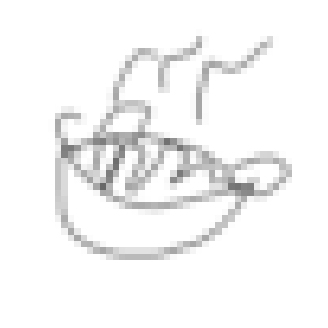

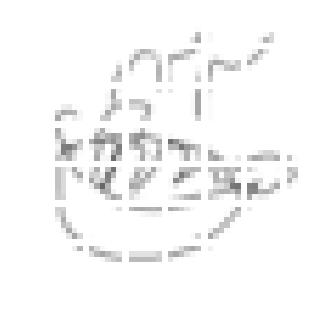

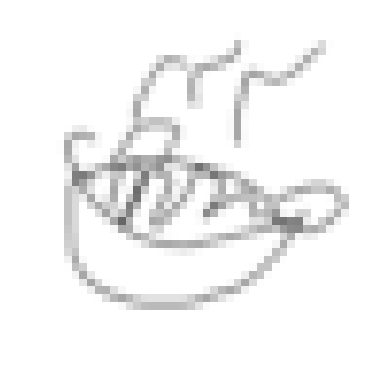

In [11]:
# Get a batch of images.
augmented_images = next(iter(train_loader))['sketch_image'][0]
augmented_images = augmented_images.unsqueeze(0) # for seva data
augmented_images = augmented_images.to(device)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images.cpu(), patches=patches.cpu())

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image.cpu())
plt.axis("off")
plt.show()

In [12]:
"""
TODO: Implements the forward method of PatchEncoder (2 points)
Hints:
    1. Pay attention to five output elements
    2. unmasked_positions are gathered unmasked postion embedding
"""

class PatchEncoder(nn.Module):
    def __init__(self, patch_size=PATCH_SIZE, projection_dim=ENC_PROJECTION_DIM,
                 mask_proportion=MASK_PROPORTION, downstream=False):
        super().__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream
        self.patch_area = patch_size * patch_size * 3
        self.num_patches = NUM_PATCHES

        self.mask_token = nn.Parameter(torch.randn(1, self.patch_area)).to(device)

        self.projection = nn.Linear(self.patch_area, self.projection_dim).to(device)
        self.position_embedding = nn.Embedding(self.num_patches, self.projection_dim).to(device)

        self.num_mask = int(self.mask_proportion * self.num_patches)

    def forward(self, patches):
        batch_size = patches.shape[0]
        positions = torch.arange(0, self.num_patches).unsqueeze(0).repeat(batch_size, 1).to(device)
        pos_embeddings = self.position_embedding(positions)

        patch_embeddings = self.projection(patches) + pos_embeddings

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)


            ################################
            # Your code starts here
            ################################
            
            mask_tokens = self.mask_token.unsqueeze(0)
            mask_tokens = mask_tokens.repeat((batch_size, self.num_patches, 1))
            
            masked_embeddings = self.projection(mask_tokens) + pos_embeddings
            
            _mask_indices = mask_indices.unsqueeze(-1).repeat(1, 1, self.projection_dim)
            _unmask_indices = unmask_indices.unsqueeze(-1).repeat(1, 1, self.projection_dim)
            
            masked_embeddings = masked_embeddings.gather(1, _mask_indices)
            
            unmasked_embeddings = patch_embeddings.gather(1, _unmask_indices)
            unmasked_positions = pos_embeddings.gather(1, _unmask_indices)
            
            mask_indices = mask_indices.unsqueeze(-1).repeat(1, 1, self.patch_area)
            unmask_indices = unmask_indices.unsqueeze(-1).repeat(1, 1, self.patch_area)

            ################################
            # Your code ends here
            ################################

            return (unmasked_embeddings, masked_embeddings,
                    unmasked_positions, mask_indices, unmask_indices)

    def get_random_indices(self, batch_size):
        rand_indices = torch.argsort(torch.rand(batch_size, self.num_patches), dim=-1).to(device)
        mask_indices = rand_indices[:, :self.num_mask].to(device)
        unmask_indices = rand_indices[:, self.num_mask:].to(device)
        return mask_indices, unmask_indices


    def generate_masked_image(self, patches, unmask_indices):
    # Choose a random patch and it corresponding unmask index.
        idx = torch.randint(0, patches.shape[0], (1,)).item()
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = torch.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

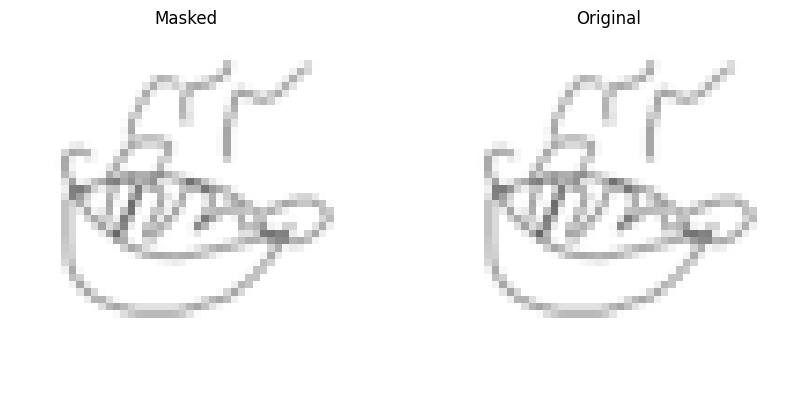

In [13]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch).cpu()
plt.imshow(img)
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index].cpu()
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title("Original")
plt.show()

In [14]:
"""
TODO: Implements the forward method of MAEEncoder and MAEDecoder (2 points)
Hints:
    1. Use all pre-defined layers
    2. Use skip connection at proper time
"""

class MAEEncoder(nn.Module):
    def __init__(self, num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS,
                 projection_dim=ENC_PROJECTION_DIM):
        super().__init__()
        self.projection_dim = projection_dim

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            # LayerNorm 1
            self.layers.append(nn.LayerNorm(projection_dim, eps=LAYER_NORM_EPS))
            # Multihead Attention
            self.layers.append(nn.MultiheadAttention(projection_dim, num_heads,
                                                     dropout=0.1, batch_first=True))

            # LayerNorm 2
            self.layers.append(nn.LayerNorm(projection_dim, eps=LAYER_NORM_EPS))
            # MLP
            self.layers.append(MLP(input_dim=projection_dim, hidden_dim=ENC_MLP_DIM,
                                   output_dim=projection_dim, dropout_prob=0.1))

        self.final_norm = nn.LayerNorm(projection_dim, eps=LAYER_NORM_EPS)

    def forward(self, x):
        ################################
        # Your code starts here
        ################################

        for layer in self.layers:
            if isinstance(layer, nn.MultiheadAttention):
                x = x + layer(x, x, x)[0]
            elif isinstance(layer, MLP):
                x = x + layer(x)
            else:
                x = layer(x)

        ################################
        # Your code ends here
        ################################

        return self.final_norm(x)

In [15]:
class MAEDecoder(nn.Module):
    def __init__(self, num_heads=DEC_NUM_HEADS, num_layers=DEC_LAYERS,
                 projection_dim=ENC_PROJECTION_DIM, image_size=IMAGE_SIZE):
        super().__init__()
        self.projection_dim = projection_dim
        self.num_patches = NUM_PATCHES

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(projection_dim, DEC_PROJECTION_DIM)) # Initial projection

        for _ in range(num_layers):
            # LayerNorm 1
            self.layers.append(nn.LayerNorm(DEC_PROJECTION_DIM, eps=LAYER_NORM_EPS))
            # Multihead Attention
            self.layers.append(nn.MultiheadAttention(DEC_PROJECTION_DIM, num_heads,
                                                     dropout=0.1, batch_first=True))

            # LayerNorm 2
            self.layers.append(nn.LayerNorm(DEC_PROJECTION_DIM, eps=LAYER_NORM_EPS))
            # MLP
            self.layers.append(MLP(input_dim=DEC_PROJECTION_DIM, hidden_dim=DEC_MLP_DIM,
                                   output_dim=DEC_PROJECTION_DIM, dropout_prob=0.1))

        self.final_norm = nn.LayerNorm(DEC_PROJECTION_DIM, eps=LAYER_NORM_EPS)
        self.pre_final = nn.Linear(self.num_patches*DEC_PROJECTION_DIM, IMAGE_SIZE * IMAGE_SIZE * 3)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        ################################
        # Your code starts here
        ################################
        
        for layer in self.layers:
            if isinstance(layer, nn.MultiheadAttention):
                x = x + layer(x, x, x)[0]
            elif isinstance(layer, MLP):
                x = x + layer(x)
            else:
                x = layer(x)

        x = self.final_norm(x)

        x = x.flatten(1)

        x = self.pre_final(x)

        x = self.activation(x)
        
        x = x.view(-1, 3, IMAGE_SIZE, IMAGE_SIZE)

        ################################
        # Your code ends here
        ################################
        return x

In [16]:
# MAE Encoder


"""
TODO: Implements the calculate_loss method of MAEAutoencoder (2 points)
Hints:
    1. total_loss: computed loss
    2. loss_patch: orignial masked patches
    3. loss_output: predicted masked patches
"""

class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_layer = Patches()
        self.patch_encoder = PatchEncoder()
        self.encoder = MAEEncoder()
        self.decoder = MAEDecoder()

    def calculate_loss(self, images, test=False):

        # Patching
        patches = self.patch_layer(images)

        # Patch Encoding
        (unmasked_embeddings, masked_embeddings, unmasked_positions,
         mask_indices, unmask_indices) = self.patch_encoder(patches)


        ################################
        # Your code starts here
        ################################
        
        device = images.device

        encoded_token = self.encoder(unmasked_embeddings)
        encoded_token = encoded_token + unmasked_positions
        decoded_token = torch.cat([encoded_token, masked_embeddings], dim=1)
                
        pred = self.decoder(decoded_token)
        pred = self.patch_layer(pred)

        loss_patch = torch.gather(patches, 1, mask_indices)
        loss_output = torch.gather(pred, 1, mask_indices)
        
        total_loss = self.compute_loss(loss_patch, loss_output)

        # total_loss = self.compute_loss(patches, pred)

        ################################
        # Your code ends here
        ################################

        return total_loss, loss_patch, loss_output

    def compute_loss(self, y, y_pred):
        return nn.MSELoss()(y, y_pred)

    def forward(self, images):
        # Patching
        patches = self.patch_layer(images)

        # Patch Encoding
        (unmasked_embeddings, masked_embeddings, unmasked_positions,
         mask_indices, unmask_indices) = self.patch_encoder(patches)

        encoded_token = self.encoder(unmasked_embeddings)
        encoded_token = encoded_token + unmasked_positions
        z = torch.cat([encoded_token, masked_embeddings], dim=1)
        
        return z
        
        # return self.calculate_loss(images)


In [17]:
def add_model_options(parser):
    group = parser.add_argument_group('Model options')
    group.add_argument("--modelname", default='motionclip_transformer_rc', help="Choice of the model, should be like motionclip_transformer_rc_rcxyz_vel")
    group.add_argument("--latent_dim", default=256, type=int, help="dimensionality of the latent space")
    group.add_argument("--lambda_rc", default=1.0, type=float, help="weight of the rc divergence loss")
    group.add_argument("--lambda_rcxyz", default=1.0, type=float, help="weight of the rc divergence loss")
    group.add_argument("--lambda_vel", default=1.0, type=float, help="weight of the vel divergence loss")
    group.add_argument("--lambda_velxyz", default=1.0, type=float, help="weight of the vel divergence loss")

    # group.add_argument("--jointstype", default="vertices", choices=JOINTSTYPES, help="Jointstype for training with xyz")

    group.add_argument('--vertstrans', dest='vertstrans', action='store_true', help="Training with vertex translations in the SMPL mesh")
    group.add_argument('--no-vertstrans', dest='vertstrans', action='store_false', help="Training without vertex translations in the SMPL mesh")
    group.set_defaults(vertstrans=False)

    group.add_argument("--num_layers", default=8, type=int, help="Number of layers for GRU and transformer")
    group.add_argument("--activation", default="gelu", help="Activation for function for the transformer layers")

    # Ablations
    group.add_argument("--ablation", choices=[None, "average_encoder", "zandtime", "time_encoding", "concat_bias", "extra_token"],
                       help="Ablations for the transformer architechture")

    # CLIP related losses
    group.add_argument("--clip_image_losses", default='cosine', help="supports multiple, underscore separated, valid options are [mse, ce]. if empty, will not train on images.")
    group.add_argument("--clip_text_losses", default='cosine', help="supports multiple, underscore separated, valid options are [mse, ce]. if empty, will not train on text.")
    group.add_argument("--clip_lambda_mse", default=1.0, type=float, help="weight of the MSE loss, for both texts and images, if in use.")
    group.add_argument("--clip_lambda_ce", default=1.0, type=float, help="weight of the CROSS-ENTROPY loss, for both texts and images, if in use.")
    group.add_argument("--clip_lambda_cosine", default=1.0, type=float, help="weight of the Cosine-dist loss, for both texts and images, if in use.")

    group.add_argument("--clip_training", default='', type=str, help="pass something here to train clip")
    group.add_argument("--clip_layers", default=12, type=int, help="# of CLIP layers to use")
    group.add_argument("--device", default='cuda', type=str, help="# of CLIP layers to use")

LOSSES = ["rc", "rcxyz", "vel", "velxyz"]

parser = ArgumentParser()
add_model_options(parser)
opt = parser.parse_known_args()

print(opt)

class OptObject:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

opt = OptObject(**vars(opt[0]))

def parse_modelname(modelname):
    modeltype, archiname, *losses = modelname.split("_")

    if len(losses) == 0:
        raise NotImplementedError("You have to specify at least one loss function.")

    for loss in losses:
        if loss not in LOSSES:
            raise NotImplementedError("This loss is not implemented.")

    return modeltype, archiname, losses

parameters = {key: val for key, val in vars(opt).items() if val is not None}

ret = parse_modelname(parameters["modelname"])
parameters["modeltype"], parameters["archiname"], parameters["losses"] = ret

# update lambdas params
lambdas = {}
for loss in parameters["losses"]:
    lambdas[loss] = opt.__getattribute__(f"lambda_{loss}")
parameters["lambdas"] = lambdas

clip_lambdas = {'image':{}, 'text':{}}
for d in clip_lambdas.keys():
    losses_name = f'clip_{d}_losses'
    print(parameters[losses_name])
    parameters[losses_name] = parameters[losses_name].split('_') if parameters[losses_name] != '' else []
    for loss in parameters[losses_name]:
        # clip_lambdas[d][loss] = getattr(opt, f"clip_lambda_{loss}", None)
        clip_lambdas[d][loss] = opt.__getattribute__(f"clip_lambda_{loss}")
parameters["clip_lambdas"] = clip_lambdas

print(parameters)
print(lambdas)
print(clip_lambdas)

(Namespace(ablation=None, activation='gelu', clip_image_losses='cosine', clip_lambda_ce=1.0, clip_lambda_cosine=1.0, clip_lambda_mse=1.0, clip_layers=12, clip_text_losses='cosine', clip_training='', device='cuda', lambda_rc=1.0, lambda_rcxyz=1.0, lambda_vel=1.0, lambda_velxyz=1.0, latent_dim=256, modelname='motionclip_transformer_rc', num_layers=8, vertstrans=False), ['--f=/home/zhuoranzhao/.local/share/jupyter/runtime/kernel-v2-194885011J3XTpuyqo6.json'])
cosine
cosine
{'modelname': 'motionclip_transformer_rc', 'latent_dim': 256, 'lambda_rc': 1.0, 'lambda_rcxyz': 1.0, 'lambda_vel': 1.0, 'lambda_velxyz': 1.0, 'vertstrans': False, 'num_layers': 8, 'activation': 'gelu', 'clip_image_losses': ['cosine'], 'clip_text_losses': ['cosine'], 'clip_lambda_mse': 1.0, 'clip_lambda_ce': 1.0, 'clip_lambda_cosine': 1.0, 'clip_training': '', 'clip_layers': 12, 'device': 'cuda', 'modeltype': 'motionclip', 'archiname': 'transformer', 'losses': ['rc'], 'lambdas': {'rc': 1.0}, 'clip_lambdas': {'image': {'c

In [18]:
import torch
import torch.nn.functional as F
# from .hessian_penalty import hessian_penalty
# from .mmd import compute_mmd

def compute_rc_loss(model, batch, use_txt_output=False):
    x = batch["sketch_image"]
    output = batch["output"]
    # mask = batch["mask"]
    # if use_txt_output:
    #     output = batch["txt_output"]
    # gtmasked = x.permute(0, 3, 1, 2)[mask]
    # outmasked = output.permute(0, 3, 1, 2)[mask]

    gtmasked = x.permute(0, 3, 1, 2)
    outmasked = output.permute(0, 3, 1, 2)

    loss = F.mse_loss(gtmasked, outmasked, reduction='mean')
    return loss


def compute_rcxyz_loss(model, batch, use_txt_output=False):
    x = batch["x_xyz"]
    output = batch["output_xyz"]
    mask = batch["mask"]
    if use_txt_output:
        output = batch["txt_output_xyz"]
    gtmasked = x.permute(0, 3, 1, 2)[mask]
    outmasked = output.permute(0, 3, 1, 2)[mask]

    loss = F.mse_loss(gtmasked, outmasked, reduction='mean')
    return loss


def compute_vel_loss(model, batch, use_txt_output=False):
    x = batch["x"]
    output = batch["output"]
    if use_txt_output:
        output = batch["txt_output"]
    gtvel = (x[..., 1:] - x[..., :-1])
    outputvel = (output[..., 1:] - output[..., :-1])

    mask = batch["mask"][..., 1:]

    gtvelmasked = gtvel.permute(0, 3, 1, 2)[mask]
    outvelmasked = outputvel.permute(0, 3, 1, 2)[mask]

    loss = F.mse_loss(gtvelmasked, outvelmasked, reduction='mean')
    return loss


def compute_velxyz_loss(model, batch, use_txt_output=False):
    x = batch["x_xyz"]
    output = batch["output_xyz"]
    if use_txt_output:
        output = batch["txt_output_xyz"]
    gtvel = (x[..., 1:] - x[..., :-1])
    outputvel = (output[..., 1:] - output[..., :-1])

    mask = batch["mask"][..., 1:]

    gtvelmasked = gtvel.permute(0, 3, 1, 2)[mask]
    outvelmasked = outputvel.permute(0, 3, 1, 2)[mask]

    loss = F.mse_loss(gtvelmasked, outvelmasked, reduction='mean')
    return loss


def compute_hp_loss(model, batch):
    loss = hessian_penalty(model.return_latent, batch, seed=torch.random.seed())
    return loss


def compute_mmd_loss(model, batch):
    z = batch["z"]
    true_samples = torch.randn(z.shape, requires_grad=False, device=model.device)
    loss = compute_mmd(true_samples, z)
    return loss


_matching_ = {"rc": compute_rc_loss, "hp": compute_hp_loss,
              "mmd": compute_mmd_loss, "rcxyz": compute_rcxyz_loss,
              "vel": compute_vel_loss, "velxyz": compute_velxyz_loss}


def get_loss_function(ltype):
    return _matching_[ltype]

In [19]:


# sketch CLIP
class SKETCHCLIP(nn.Module):
    def __init__(self, encoder, decoder, clip_model, lambdas, clip_lambdas, device, input_dim, output_dim):
        super(SKETCHCLIP, self).__init__()
        
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.clip_model = clip_model.to(device)
        self.lambdas = lambdas
        self.clip_lambdas = clip_lambdas
        self.device = device
        
        self.fc = nn.Linear(input_dim, output_dim).to(device)
        # self.decode_fc = nn.Linear(output_dim, input_dim).to(device)
        self.decode_fc = nn.Sequential(
            nn.Linear(output_dim, (output_dim + input_dim) // 2), # First Linear Layer
            nn.ReLU(), # Non-linearity
            nn.Dropout(0.1), # Regularization
            nn.Linear((output_dim + input_dim) // 2, input_dim) # Output Layer
        ).to(device)
        self.activation = nn.ReLU()
        
        # Freeze encoder
        self._freeze_encoder()
    
    def _freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def compute_loss(self, batch):
        # compute all losses other than clip
        mixed_loss = 0.
        losses = {}

        for ltype, lam in self.lambdas.items():
            loss_function = get_loss_function(ltype)
            loss = loss_function(self, batch)
            mixed_loss += loss * lam
            losses[ltype] = loss.item()

        # compute clip losses
        mixed_clip_loss, clip_losses = self.compute_clip_losses(batch)

        # mix and add clip losses
        mixed_loss_with_clip = mixed_loss + mixed_clip_loss  # this is the ultimate loss to optimize, combining ALL losses
        losses.update(clip_losses)
        losses["mixed_without_clip"] = mixed_loss.item()
        losses["mixed_clip_only"] = mixed_clip_loss if isinstance(mixed_clip_loss, float) else mixed_clip_loss.item()
        losses["mixed_with_clip"] = mixed_loss_with_clip if isinstance(mixed_loss_with_clip,
                                                                       float) else mixed_loss_with_clip.item()

        return mixed_loss_with_clip, losses
    
    def compute_rc_loss(model, batch, use_txt_output=False):
        x = batch["sketch_image"]
        output = batch["output"]

        gtmasked = x.permute(0, 3, 1, 2)
        outmasked = output.permute(0, 3, 1, 2)

        loss = F.mse_loss(gtmasked, outmasked, reduction='mean')
        return loss
    
    def compute_clip_losses(self, batch):
        mixed_clip_loss = 0.
        clip_losses = {}
        
        for d in self.clip_lambdas.keys():
            if len(self.clip_lambdas[d].keys()) == 0:
                continue
            with torch.no_grad():
                if d == 'image':
                    features = self.clip_model.encode_image(
                        batch['object_image'].permute(0, 3, 1, 2)).float()  # preprocess is done in dataloader
                elif d == 'text':
                    texts = clip.tokenize(batch['text']).to(self.device)
                    features = self.clip_model.encode_text(texts).float()
                else:
                    raise ValueError(f'Invalid clip domain [{d}]')

            # normalized features
            features_norm = features / features.norm(dim=-1, keepdim=True)
            # features_norm = self.activation(self.decode_fc(features_norm))
            features_norm = self.decode_fc(features_norm)
            features_norm = features_norm.reshape(features_norm.shape[0], batch["z"].shape[1], -1)
            
            seq_motion_features_norm = batch["z"] / batch["z"].norm(dim=-1, keepdim=True)

            if 'ce' in self.clip_lambdas[d].keys():
                logit_scale = self.clip_model.logit_scale.exp()
                logits_per_motion = logit_scale * seq_motion_features_norm @ features_norm.t()
                logits_per_d = logits_per_motion.t()

                batch_size = batch['sketch_image'].shape[0]
                ground_truth = torch.arange(batch_size, dtype=torch.long, device=self.device)

                ce_from_motion_loss = loss_ce(logits_per_motion, ground_truth)
                ce_from_d_loss = loss_ce(logits_per_d, ground_truth)
                clip_mixed_loss = (ce_from_motion_loss + ce_from_d_loss) / 2.

                clip_losses[f'{d}_ce_from_d'] = ce_from_d_loss.item()
                clip_losses[f'{d}_ce_from_motion'] = ce_from_motion_loss.item()
                clip_losses[f'{d}_mixed_ce'] = clip_mixed_loss.item()
                mixed_clip_loss += clip_mixed_loss * self.clip_lambdas[d]['ce']

            if 'mse' in self.clip_lambdas[d].keys():
                mse_clip_loss = loss_mse(features, batch["z"])
                clip_losses[f'{d}_mse'] = mse_clip_loss.item()
                mixed_clip_loss += mse_clip_loss * self.clip_lambdas[d]['mse']

            if 'cosine' in self.clip_lambdas[d].keys():
                cos = cosine_sim(features_norm, seq_motion_features_norm)
                cosine_loss = (1 - cos).mean()
                clip_losses[f'{d}_cosine'] = cosine_loss.item()
                mixed_clip_loss += cosine_loss * self.clip_lambdas[d]['cosine']
        
        return mixed_clip_loss, clip_losses
    
    def generate_from_image(self, image):
        # features = self.clip_model.encode_image(
        #                 image.permute(0, 3, 1, 2)).float()
        features = self.clip_model.encode_image(
                        image).float()
        features_norm = features / features.norm(dim=-1, keepdim=True)
        # features_norm = self.activation(self.decode_fc(features_norm))
        features_norm = self.decode_fc(features_norm)
        features_norm = features_norm.reshape(features_norm.shape[0], DEC_PROJECTION_DIM, -1)
        
        pred = self.decoder(features_norm)
        gen_sketch = pred[0].detach().cpu().permute(1,2,0)
        
        input_image = image[0].cpu()

        # Plot the input image and the generated sketch
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        # Input image
        ax[0].imshow(input_image.permute(1,2,0))
        ax[0].set_title("Input Image")
        ax[0].axis('off')  # Hide axes for a clean visualization

        # Generated sketch
        ax[1].imshow(gen_sketch.numpy())
        ax[1].set_title("Generated Sketch")
        ax[1].axis('off')  # Hide axes for a clean visualization

        plt.tight_layout()
        plt.show()
        
        return features_norm

    def generate_from_text(self, text):
        texts = clip.tokenize(text).to(self.device)
        features = self.clip_model.encode_text(texts).float()
        features_norm = features / features.norm(dim=-1, keepdim=True)
        # features_norm = self.activation(self.decode_fc(features_norm))
        features_norm = self.decode_fc(features_norm)
        features_norm = features_norm.reshape(features_norm.shape[0], DEC_PROJECTION_DIM, -1)
        
        pred = self.decoder(features_norm)
        gen_sketch = pred[0].detach().cpu().permute(1,2,0)
        
        # Display the generated sketch using matplotlib
        plt.imshow(gen_sketch.numpy())
        plt.axis('off')  # Hide axes for better visualization
        plt.title(f"Generated Sketch for: {text}")
        plt.show()
        
        return features_norm
    
    def generate_from_sketch(self, image):
        latent_z = self.encoder(image.to(self.device))
        # batch["z"] = latent_z
        # latent_z_reshape = latent_z.view(latent_z.size(0), -1)
        # batch["z"] = self.activation(self.fc(latent_z_reshape))

        # decode
        # pred = self.decoder(latent_z)
        pred = self.decoder(latent_z)
        gen_sketch = pred[0].detach().cpu().permute(1,2,0)
        
        input_image = image[0].cpu()

        # Plot the input image and the generated sketch
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        # Input image
        ax[0].imshow(input_image.permute(1,2,0), interpolation='none', vmin=0, vmax=1)
        ax[0].set_title("Input Sketch Image")
        ax[0].axis('off')  # Hide axes for a clean visualization

        # Generated sketch
        ax[1].imshow(gen_sketch.numpy(), interpolation='none', vmin=0, vmax=1)
        ax[1].set_title("Generated Sketch")
        ax[1].axis('off')  # Hide axes for a clean visualization

        plt.tight_layout()
        plt.show()
        
        return latent_z

    def forward_codebook(self, latent_z):
        pred = self.decoder(latent_z)
        gen_sketch = pred[0].detach().cpu().permute(1,2,0)

        # Plot the input image and the generated sketch
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        cv2.imwrite('sketch.png', gen_sketch.numpy()*255)

        # Generated sketch
        ax.imshow(gen_sketch.numpy())
        ax.set_title("Generated Sketch")
        ax.axis('off')  # Hide axes for a clean visualization

        plt.tight_layout()
        plt.show()


    def forward(self, batch):
        # encode
        latent_z = self.encoder(batch['sketch_image'].to(self.device))
        # batch["z"] = latent_z
        # latent_z_reshape = latent_z.view(latent_z.size(0), -1)
        # batch["z"] = self.activation(self.fc(latent_z_reshape))
        batch["z"] = latent_z

        # decode
        # pred = self.decoder(latent_z)
        pred = self.decoder(batch["z"])
        batch["output"] = pred

        return batch

In [20]:
# CLIP model
def init_CLIP(parameters, split="train"):

    # clip_model, preprocess = clip.load("ViT-B/32", device=device)  # Must set jit=False for training
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=parameters['device'], jit=False)  # Must set jit=False for training
    clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16

    for domain in parameters.get('clip_training', '').split('_'):
        clip_num_layers = parameters.get('clip_layers', 12)
        if domain == 'text':
            clip_model.initialize_parameters()
            clip_model.transformer.resblocks = clip_model.transformer.resblocks[:clip_num_layers]
        if domain == 'image':
            clip_model.initialize_parameters()
            clip_model.visual.transformer = clip_model.transformer.resblocks[:clip_num_layers]

    # NO Clip Training ,Freeze CLIP weights
    if parameters.get('clip_training', '') == '':
        clip_model.eval()
        for p in clip_model.parameters():
            p.requires_grad = False
    
    return clip_model, clip_preprocess

# clip_model = init_CLIP(parameters=parameters)
# print(dir(clip_model))

In [21]:
encoder_model = MaskedAutoencoder()
# checkpoint = torch.load('/mnt/sdc/zhuoran/mae_sketch_ckpt/800_checkpoint.pth')
# encoder_model.load_state_dict(checkpoint['model_state_dict'])
encoder_model = encoder_model.to(device)

clip_model, clip_preprocess = init_CLIP(parameters=parameters)

sketch_clip_model = SKETCHCLIP(
    encoder=encoder_model,
    decoder=MAEDecoder(num_layers=6),
    clip_model=clip_model,
    lambdas=lambdas,
    clip_lambdas=clip_lambdas,
    device=device,
    input_dim=64*128,
    output_dim=512,
).to(device)

In [22]:
checkpoint = torch.load('./sketch_model_dc_large_enc_lam_ce2_continue/best_checkpoint.pth')
sketch_clip_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [23]:
optimizer = torch.optim.Adam(sketch_clip_model.parameters(), lr=LEARNING_RATE)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5.5506251901499275e-09


In [24]:
# Load checkpoint
checkpoint = torch.load('./sketch_model_dc_large_enc_lam_ce2_continue/best_checkpoint.pth')
print(checkpoint['epoch'])
# Load model state
sketch_clip_model.load_state_dict(checkpoint['model_state_dict'])

393


<All keys matched successfully>

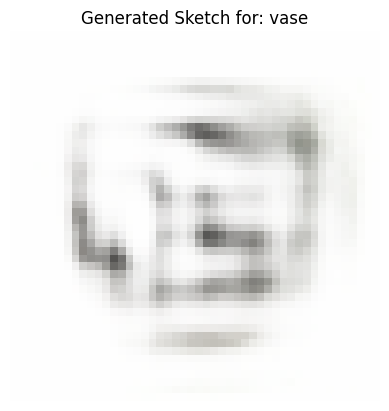

In [25]:
sketch_clip_model.eval()
text_embed = sketch_clip_model.generate_from_text('vase')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


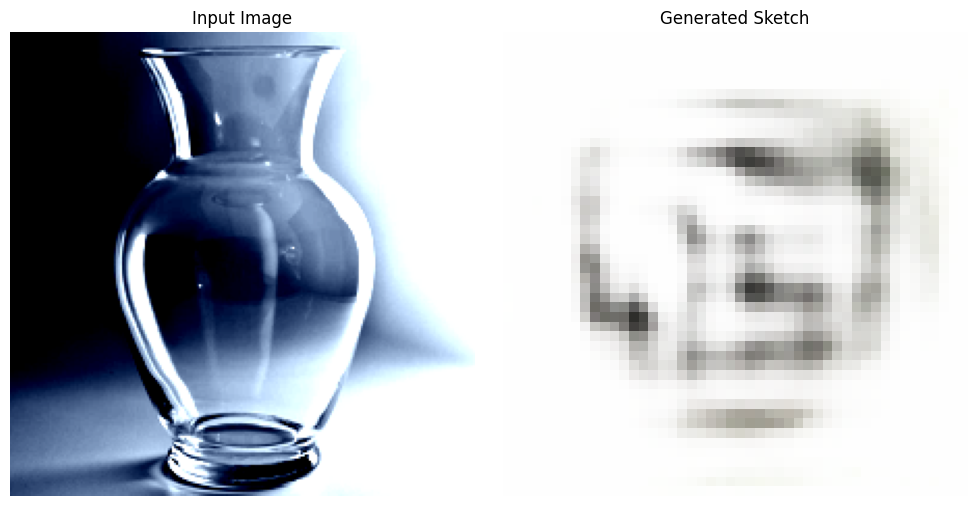

In [26]:
sketch_clip_model.eval()
# image_path = '/mnt/sdc/zhuoran/object_images/taxi/taxi_04s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/hat/hat_12s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/bracelet2/bracelet2_02s.jpg'
image_path = '/mnt/sdc/zhuoran/object_images/vase/vase_13s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/jeans/jeans_08s.jpg'
# image_path =  '/mnt/sdc/zhuoran/object_images/beer/beer_13s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/milkshake/milkshake_09s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/puffin/puffin_24s.jpg'
# image_path = '/mnt/sdc/zhuoran/object_images/honeypot/honeypot_17s.jpg'
# taxi_img = cv2.imread(image_path)
# taxi_img = cv2.cvtColor(taxi_img, cv2.COLOR_BGR2RGB)
# taxi_img = cv2.resize(taxi_img, (224, 224))
# taxi_img = torch.tensor(taxi_img).unsqueeze(0).to(device)

img_embed = sketch_clip_model.generate_from_image(clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device))

In [ ]:
# create codebook

file_path = "/mnt/sdc/zhuoran/neurips_DB_human_clean.csv"
obj_img_path = "/mnt/sdc/zhuoran/object_images/"
sketch_img_path = "/mnt/sdc/zhuoran/seva_production_pngs"

def get_train_augmentation_transforms():  
    return transforms.Compose([
        transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(1, 1)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

transform = get_train_augmentation_transforms()

code_book = {}

with open(file_path, mode='r', newline='') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    rows = list(csv_reader)
    
    for idx, row in enumerate(reversed(rows)):
        if idx == 0:
            continue

        sketch_id = row[0]
        sketch_path = os.path.join(sketch_img_path, sketch_id + '.png')
        text = row[1]
        text_str = row[3]
        img_name = row[2]
        img_path = os.path.join(obj_img_path, text_str, img_name)
        
        if text == 'concept':
            continue
        
        if text not in code_book:
            
            try:
                img = cv2.imread(sketch_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(img)
                img = transform(img).unsqueeze(0).to(device)

                sketch_embed = sketch_clip_model.generate_from_sketch(img)
                
                code_book[text] = sketch_embed
            except:
                print(text)


In [33]:
text_embed = F.normalize(text_embed, p=2, dim=1)

score_list = {}

for key in code_book:
    embed = code_book[key]
    
    similar_score = (F.normalize(embed, p=2, dim=1) * text_embed).sum(dim=1).mean()
    
    score_list[key] = similar_score
    
top_ten = dict(sorted(score_list.items(), key=lambda item: item[1], reverse=True)[:10])
top_ten_keys = [key for key, value in sorted(score_list.items(), key=lambda item: item[1], reverse=True)[:10]]


print("Top Ten Scores:")
for key, value in top_ten.items():
    print(f"{key}: {value}")

# Print a specific score for 'vase'
print("\nScore for 'vase':", score_list['vase'])

Top Ten Scores:
vase: 0.10025805234909058
cupcake: 0.09214332699775696
coaster: 0.08840683102607727
cymbal: 0.08133669942617416
computer screen: 0.08027556538581848
bag: 0.07405620068311691
lion: 0.07355134934186935
kneepad: 0.07290242612361908
milkshake: 0.0674140676856041
extinguisher: 0.06694389879703522

Score for 'vase': tensor(0.1003, device='cuda:0', grad_fn=<MeanBackward0>)


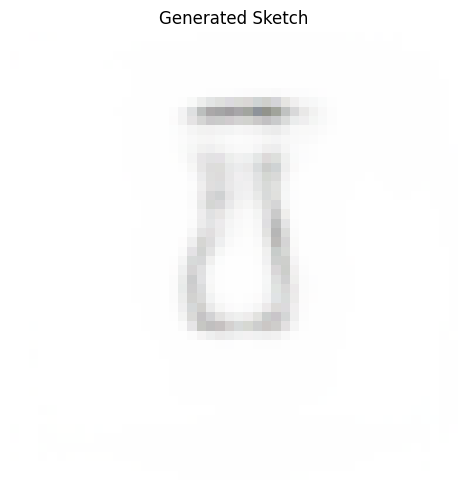

In [34]:
sketch_clip_model.forward_codebook(code_book[top_ten_keys[0]])